This notebook is primary geared towards looking at the algorithm output.

In particular, since the compute job was stopped due to Cheyenne maintenance, I save intermediate $w$, $c$, and $\lambda$ vectors to `./data/results/00/...`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.optimize import minimize

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [3]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# Look at $w$ optimization trajectory

Naming convention:
1. Indices in job name are from 0. So, "from_it2" is iteration two indexed from 0.
2. Indices in python variable names are from 1.

In [6]:
# read in the raw stdout file
with open(BASE_DIR + '/02/stdout.txt', 'r') as f:
    stdout_raw = f.readlines()

# standard out starting from iteration 2
with open(BASE_DIR + '/02/stdout_from_it2.txt', 'r') as f:
    stdout_raw_it2 = f.readlines()
    
# standard out starting from iteration 2
with open(BASE_DIR + '/02/stdout_from_it5.txt', 'r') as f:
    stdout_raw_it5 = f.readlines()

In [7]:
# isolate the trajectories from the second w optimization
all_obj_vals = [float(line[22:34].replace('D', 'e')) for line in stdout_raw if 'At iterate' in line]
traj_w_01 = all_obj_vals[:13]
traj_c_01 = all_obj_vals[13:17]
traj_w_02 = all_obj_vals[17:30]
traj_c_02 = all_obj_vals[30:]

In [8]:
# starting from iteration 2 (indexed from 0)
all_obj_vals_it2 = [
    float(line[22:34].replace('D', 'e')) for line in stdout_raw_it2 if 'At iterate' in line
]

traj_w_03 = all_obj_vals_it2[:3]
traj_c_03 = all_obj_vals_it2[3:6]
traj_w_04 = all_obj_vals_it2[6:11]
traj_c_04 = all_obj_vals_it2[11:14]
traj_w_05 = all_obj_vals_it2[14:20]
traj_c_05 = all_obj_vals_it2[20:23]

In [11]:
# starting from iteration 5 (indexed from 0)
all_obj_vals_it5 = [
    float(line[22:34].replace('D', 'e')) for line in stdout_raw_it5 if 'At iterate' in line
]

traj_w_06 = all_obj_vals_it5[:7]
traj_c_06 = all_obj_vals_it5[7:10]
traj_w_07 = all_obj_vals_it5[10:23]
traj_c_07 = all_obj_vals_it5[23:26]
traj_w_08 = all_obj_vals_it5[26:39]
traj_c_08 = all_obj_vals_it5[39:42]
traj_w_09 = all_obj_vals_it5[42:]

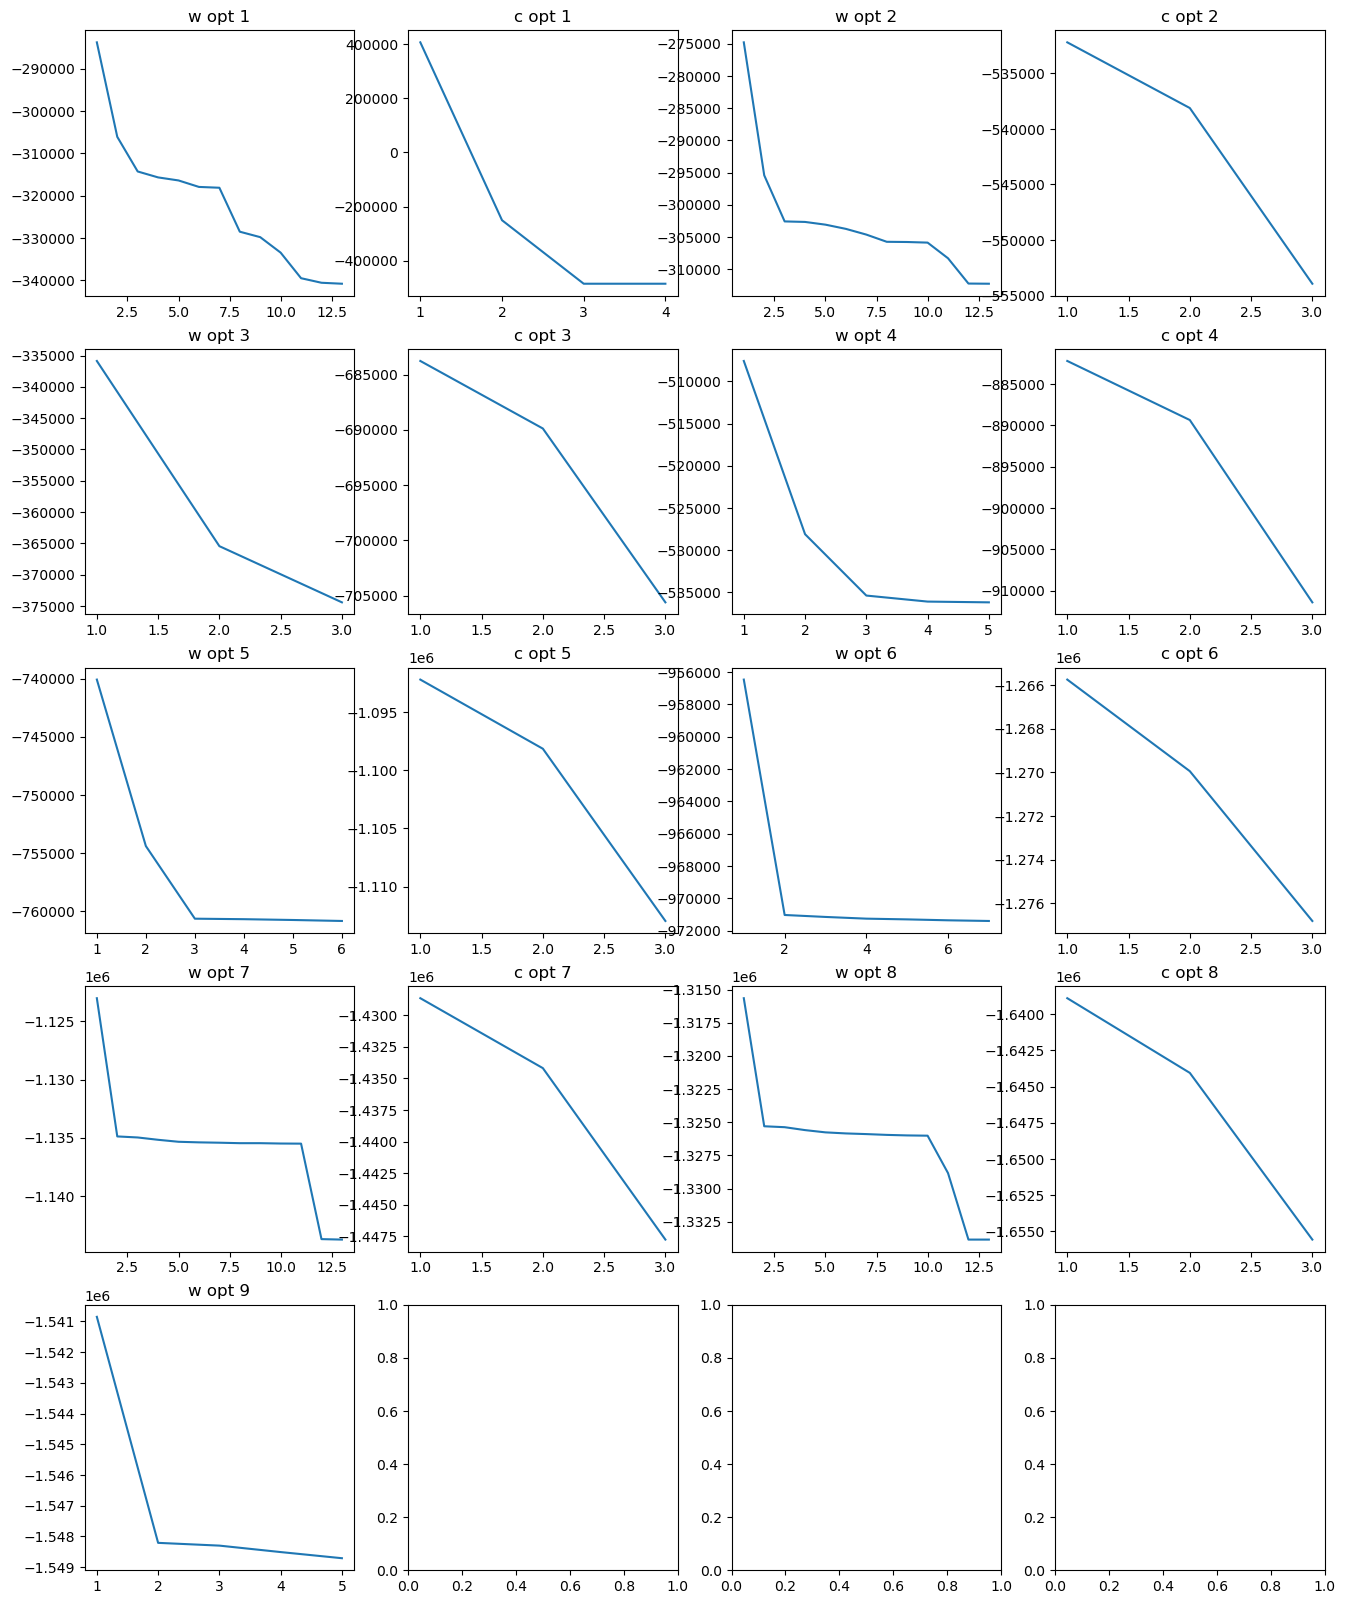

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 20))

# plots

# iteration 0
ax[0, 0].plot(np.arange(1, 14), traj_w_01)
ax[0, 1].plot(np.arange(1, 5), traj_c_01)

# iteration 1
ax[0, 2].plot(np.arange(1, 14), traj_w_02)
ax[0, 3].plot(np.arange(1, 4), traj_c_02)

# iteration 2
ax[1, 0].plot(np.arange(1, 4), traj_w_03)
ax[1, 1].plot(np.arange(1, 4), traj_c_03)

# iteration 4
ax[1, 2].plot(np.arange(1, len(traj_w_04) + 1), traj_w_04)
ax[1, 3].plot(np.arange(1, len(traj_c_04) + 1), traj_c_04)

# iteration 5
ax[2, 0].plot(np.arange(1, len(traj_w_05) + 1), traj_w_05)
ax[2, 1].plot(np.arange(1, len(traj_c_05) + 1), traj_c_05)

# iteration 6
ax[2, 2].plot(np.arange(1, len(traj_w_06) + 1), traj_w_06)
ax[2, 3].plot(np.arange(1, len(traj_c_06) + 1), traj_c_06)

# iteration 7
ax[3, 0].plot(np.arange(1, len(traj_w_07) + 1), traj_w_07)
ax[3, 1].plot(np.arange(1, len(traj_c_07) + 1), traj_c_07)

# iteration 8
ax[3, 2].plot(np.arange(1, len(traj_w_08) + 1), traj_w_08)
ax[3, 3].plot(np.arange(1, len(traj_c_08) + 1), traj_c_08)

# iteration 9
ax[4, 0].plot(np.arange(1, len(traj_w_09) + 1), traj_w_09)

# titles
ax[0, 0].set_title('w opt 1')
ax[0, 1].set_title('c opt 1')
ax[0, 2].set_title('w opt 2')
ax[0, 3].set_title('c opt 2')
ax[1, 0].set_title('w opt 3')
ax[1, 1].set_title('c opt 3')
ax[1, 2].set_title('w opt 4')
ax[1, 3].set_title('c opt 4')
ax[2, 0].set_title('w opt 5')
ax[2, 1].set_title('c opt 5')
ax[2, 2].set_title('w opt 6')
ax[2, 3].set_title('c opt 6')
ax[3, 0].set_title('w opt 7')
ax[3, 1].set_title('c opt 7')
ax[3, 2].set_title('w opt 8')
ax[3, 3].set_title('c opt 8')
ax[4, 0].set_title('w opt 9')

plt.show()

# Feasibility Condition

\begin{equation}
\lVert h + A^T c - K^T w \rVert_2^2
\end{equation}

In [14]:
# import h
with open('./data/carbon_flux/objects/na_june_functional.npy', 'rb') as f:
    h = np.load(f)

# import A
A, b = A_b_generation(
    box_constraint_fp='./data/carbon_flux/objects/scipy_bnds.pkl'
)

print(f'Dim of A: {A.shape}')
print(f'Dim of b: {b.shape}')

Dim of A: (11120, 26496)
Dim of b: (11120,)


#### Starting feasibility

In [15]:
# read in starting points
START_POINT_DIR = './data/carbon_flux/results/02/intermediate_starts/'

with open(START_POINT_DIR + '/cheyenne_stop_w_vec.npy', 'rb') as f:
    w_sp = np.load(f)
with open(START_POINT_DIR + '/cheyenne_stop_c_vec.npy', 'rb') as f:
    c_sp = np.load(f)

In [16]:
# read in K^T w for starting w
with open('../fixed_optimization_inputs/KTw_for_w_start.npy', 'rb') as f:
    KTw_0 = np.load(f)

In [17]:
np.linalg.norm(h + A.T @ c_sp - KTw_0)

16.994936714923163

#### Feasibilitiy after first iteration

In [18]:
def read_res_dict(path):
    with open(path, 'rb') as f:
        res_dict = pickle.load(f)
    return res_dict

def extract_feasibility_values(res_dict):
    """ Takes dictionary output from each stage and computes feasibility vector """
    # extract plotting objects from results_dict
    KTw_vecs = res_dict['KTw_vecs'].copy()
    c_vecs = res_dict['c_opt_vecs'].copy()

    # look at the norm of the constraint term
    num_iters = KTw_vecs.shape[0]

    constr_mat = np.array([
        h + A.T @ c_vecs[i, :] - KTw_vecs[i, :]
        for i in range(num_iters)
    ])
    feasibility = np.sqrt(np.diagonal(constr_mat @ constr_mat.T))
    
    return feasibility

In [20]:
# read in results dictionaries
MAX_ITER = 8
path_i = lambda x: BASE_DIR + f'/02/opt_output_{str(x).zfill(2)}.pkl'
res_dicts = {i:read_res_dict(path_i(i)) for i in range(1, MAX_ITER)}

In [21]:
# compute feasibility values
feasibility_arrs = {i:extract_feasibility_values(res_dicts[i]) for i in range(1, MAX_ITER)}

In [24]:
# save the disparate feasibility values (from extracting values from feasibilty_arrs)
feas_vals = [
    16.994936714923163,
    10.97259036, 
    8.17085017,
    6.33246292,
    5.55073525,
    5.14307083,
    4.81424152,
    4.2595164,
    4.18414476
]

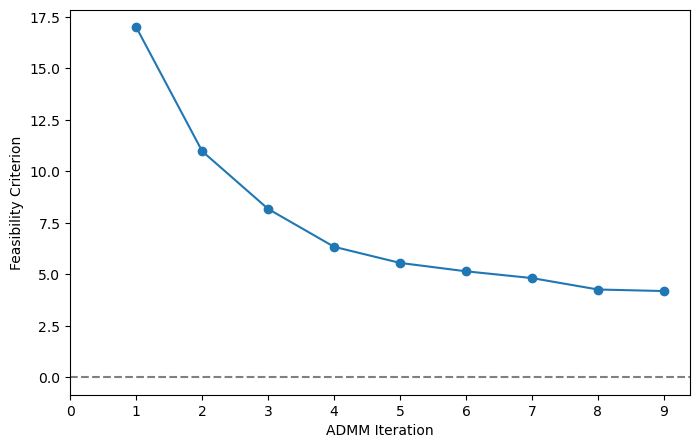

In [28]:
plt.figure(figsize=(8, 5))
x_s = np.arange(1, len(feas_vals) + 1)
plt.plot(x_s, feas_vals)
plt.scatter(x_s, feas_vals)
plt.axhline(0, linestyle='--', color='gray')

plt.xticks(np.arange(len(feas_vals) + 1))

plt.xlabel('ADMM Iteration')
plt.ylabel('Feasibility Criterion')

plt.show()

In [26]:
# current endpoint value?
for i in range(1, MAX_ITER):
    print(res_dicts[i]['objective_evals'])

[-28976.74552516779, -33522.524430791666]
[-36688.28142090911]
[-36688.28142090911, -40172.51588115038]
[-36688.28142090911, -40172.51588115038, -43261.87638743066]
[-45603.95089074058]
[-45603.95089074058, -49494.9718371285]
[-45603.95089074058, -49494.9718371285, -53312.42172451793]


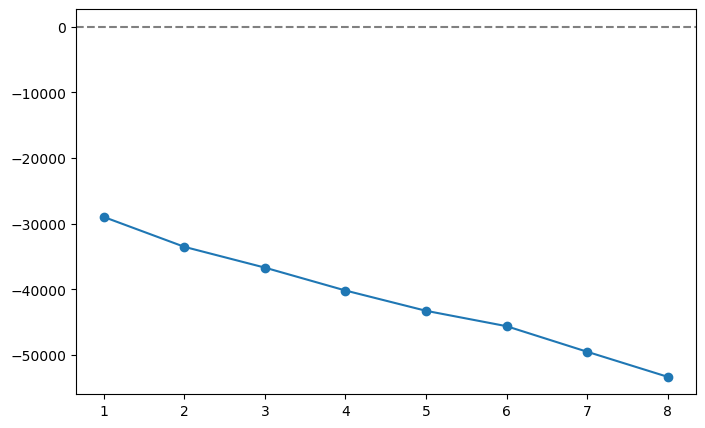

In [27]:
# plot endpoint values
endpoint_vals = [
    -28976.74552516779, -33522.524430791666, -36688.28142090911,
    -40172.51588115038, -43261.87638743066, -45603.95089074058,
    -49494.9718371285, -53312.42172451793
]

plt.figure(figsize=(8, 5))
x_s = np.arange(1, len(endpoint_vals) + 1)
plt.plot(x_s, endpoint_vals)
plt.scatter(x_s, endpoint_vals)
plt.axhline(0, linestyle='--', color='gray')
plt.show()

# Save new starting points

#### For ADMM iteration 2

In [41]:
# isolate the starting vectors
w_start_02 = res_dict['w_opt_vecs'][1, :].copy()
c_start_02 = res_dict['c_opt_vecs'][1, :].copy()
lambda_start_02 = res_dict['lambda_opt_vecs'][1, :].copy()

In [42]:
# output vectors
with open(BASE_DIR + '/02/intermediate_starts/w_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=w_start_02)

with open(BASE_DIR + '/02/intermediate_starts/c_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=c_start_02)

with open(BASE_DIR + '/02/intermediate_starts/lambda_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=lambda_start_02)

#### For ADMM iteration 5

In [11]:
# read in the previous progress
with open(BASE_DIR + '/02/opt_output_04.pkl', 'rb') as f:
    res_dict_04 = pickle.load(f)

In [19]:
# save the new starting vectors
w_start_05 = res_dict_04['w_opt_vecs'][4, :].copy()
c_start_05 = res_dict_04['c_opt_vecs'][4, :].copy()
lambda_start_05 = res_dict_04['lambda_opt_vecs'][4, :].copy()

In [23]:
# output vectors
with open(BASE_DIR + '/02/intermediate_starts/w_start_it5.npy', 'wb') as f:
    np.save(file=f, arr=w_start_05)

with open(BASE_DIR + '/02/intermediate_starts/c_start_it5.npy', 'wb') as f:
    np.save(file=f, arr=c_start_05)

with open(BASE_DIR + '/02/intermediate_starts/lambda_start_it5.npy', 'wb') as f:
    np.save(file=f, arr=lambda_start_05)